# Feature Visualization: Understanding Neural Networks Through Optimization

## 1. Introduction
In this notebook, we'll go over some of the concepts covered by the Distill.pub article [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/).



## 2. Basic Concept: Optimization-Based Visualization

Feature visualization helps us understand what neural networks are looking for by generating images that maximize certain activations. Think of it like creating the "ideal" input that a particular part of the network wants to see.

In the forward pass of a typical neural network you have:

*Input image → Network → Activations*

We usually care about the final output (like for perhaps classification).

Feature visualization flips this around and turns the focus to the activations of the interal structure of the network:
1. Start with random noise
2. Look at activation of a specific neuron/channel/layer
3. Modify the image to increase that activation
4. Repeat until we get an image that strongly activates our target


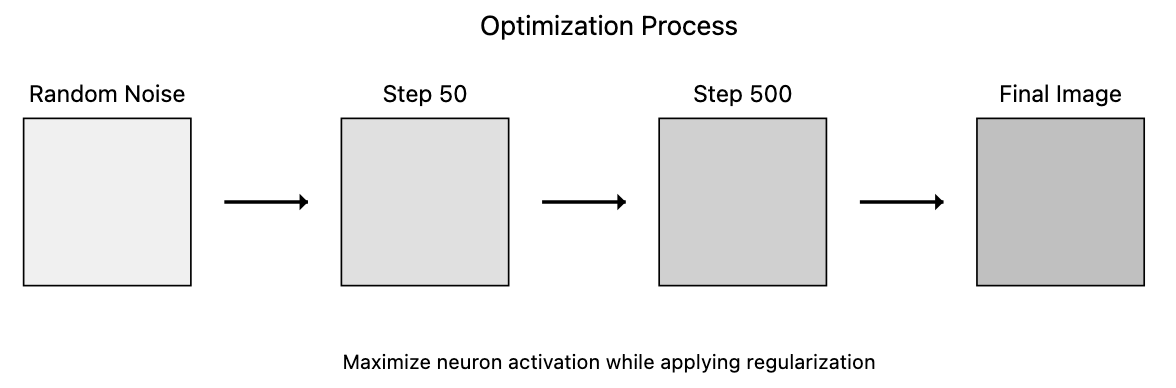

In [ ]:
from IPython.display import display, HTML
from IPython.display import Image as Im
display(Im('activation_optimization.png', height=300, width=920))

During this process, the starting (noise) image is iteratively updated in accordance with what maximizes certain activations in the target neuron/layer. This leaves us with an image that would "ideally" activate the particular neuron that we're focusing on, in turn telling us what that neuron is sensitive to.

Let's try it out!
We'll start with a noise image, and a basic model (ResNet18).
Then, we'll get the activations due to that image, and make sure that we update the image according to what maximizes the activations in question.

Step 0, Activation: 0.00
Step 200, Activation: 0.41
Step 400, Activation: 0.50
Step 600, Activation: 0.55
Step 800, Activation: 0.59


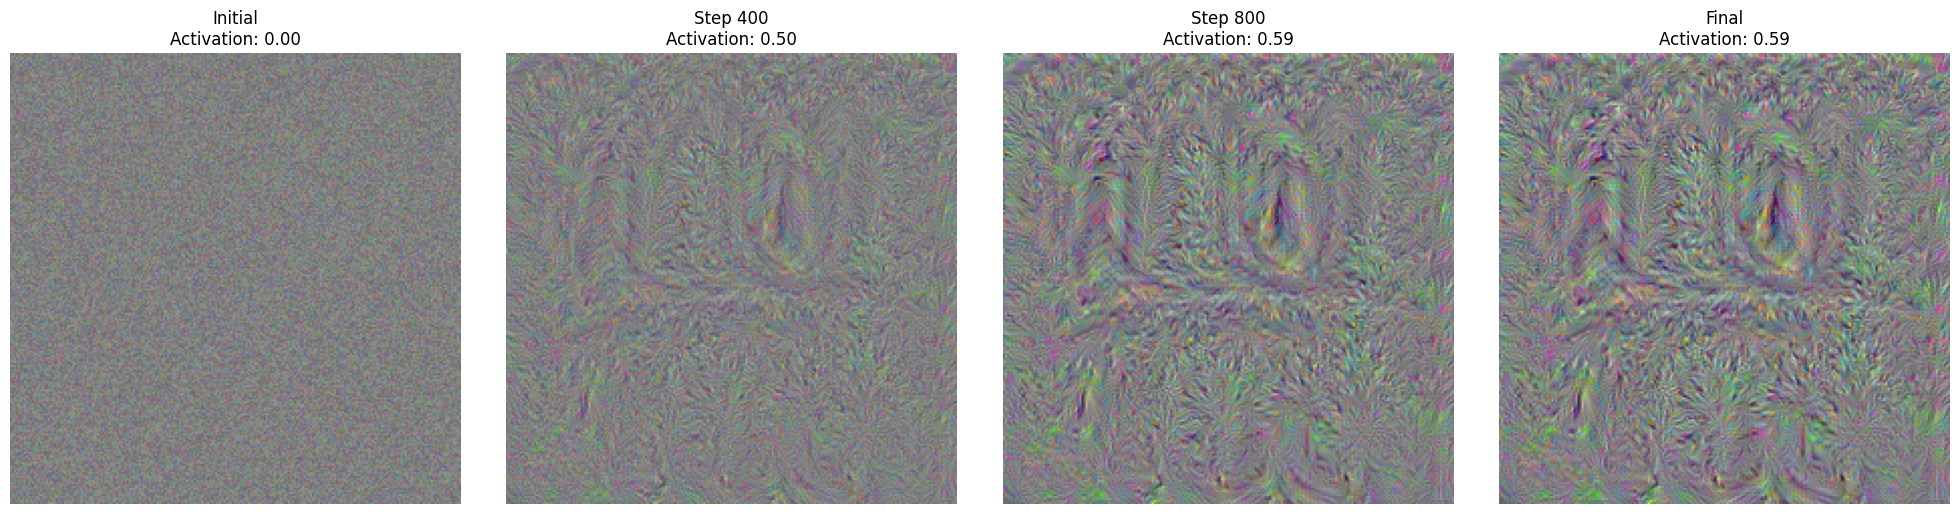

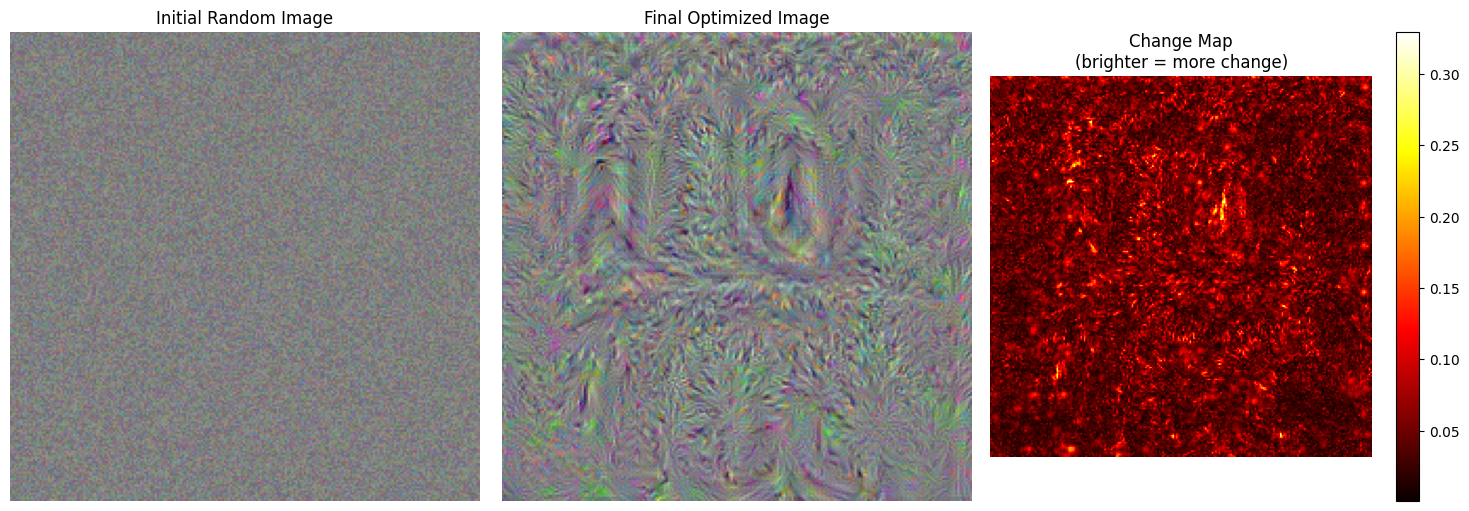

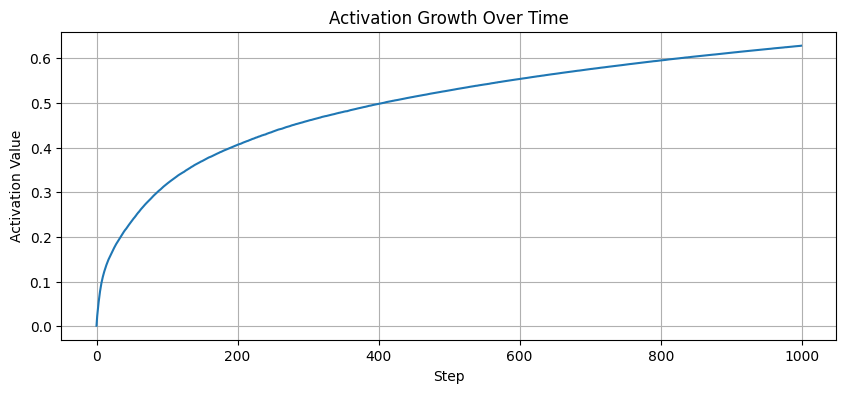

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

def create_random_image(size=224):
    """Create a random starting image"""
    # Start with lower contrast noise to make changes more visible
    img = np.random.uniform(0.4, 0.6, (3, size, size))
    return torch.FloatTensor(img)

def hook_layer(model, layer_name):
    activation = {}
    def hook(model, input, output):
        activation['value'] = output

    layer = dict([*model.named_modules()])[layer_name]
    handle = layer.register_forward_hook(hook)
    return activation, handle

def visualize_neuron_evolution(model, layer_name, channel_idx, num_steps=1000, learning_rate=5.0, save_every=200):
    """Feature visualization with proper history tracking"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    # Create random image
    img = create_random_image().to(device)
    img.requires_grad = True

    # Setup hook
    activation, handle = hook_layer(model, layer_name)

    # Keep track of history
    activation_history = []
    image_history = []

    # Save initial state (make a deep copy!)
    image_history.append(img.detach().cpu().clone().numpy())

    # Optimization loop
    for i in range(num_steps):
        # Forward pass
        model(img.unsqueeze(0))

        # Get activation
        acts = activation['value']
        act_value = torch.mean(acts[0, channel_idx]).item()
        activation_history.append(act_value)

        # Save image at intervals (make deep copies!)
        if i % save_every == 0:
            image_history.append(img.detach().cpu().clone().numpy())
            print(f"Step {i}, Activation: {act_value:.2f}")

        # Define loss and backward pass
        loss = -torch.mean(acts[0, channel_idx])
        loss.backward()

        # Update image
        with torch.no_grad():
            img -= learning_rate * img.grad
            img.data.clamp_(0.1, 0.9)
            img.grad.zero_()

    # Clean up
    handle.remove()

    return image_history, activation_history

# Run visualization
model = models.resnet18(pretrained=True)
image_history, activation_history = visualize_neuron_evolution(
    model, 'layer3.1.conv2', 50,
    num_steps=1000,
    learning_rate=5.0
)

# Visualization with multiple stages
plt.figure(figsize=(20, 5))

# Show evolution stages
stages = [0, 2, 4, -1]  # Show more intermediate steps
titles = ['Initial', 'Step 400', 'Step 800', 'Final']

for i, (stage, title) in enumerate(zip(stages, titles)):
    plt.subplot(141 + i)
    plt.imshow(np.transpose(image_history[stage], (1,2,0)))
    plt.title(f'{title}\nActivation: {activation_history[stage*200]:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Show difference map
plt.figure(figsize=(15, 5))

# Initial
plt.subplot(131)
plt.imshow(np.transpose(image_history[0], (1,2,0)))
plt.title('Initial Random Image')
plt.axis('off')

# Final
plt.subplot(132)
plt.imshow(np.transpose(image_history[-1], (1,2,0)))
plt.title('Final Optimized Image')
plt.axis('off')

# Difference
diff = np.abs(image_history[-1] - image_history[0])
diff = np.transpose(diff, (1,2,0)).mean(axis=2)  # Average across color channels
plt.subplot(133)
plt.imshow(diff, cmap='hot')
plt.title('Change Map\n(brighter = more change)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

# Plot activation growth
plt.figure(figsize=(10, 4))
plt.plot(activation_history)
plt.title('Activation Growth Over Time')
plt.xlabel('Step')
plt.ylabel('Activation Value')
plt.grid(True)
plt.show()

## 3. Beyond Neurons: Directions in Activation Space

### 3.1 Neurons as Basis Vectors in Activation Space

Any neural network can be interpreted as having an "activation space", which specifies the "strength" of signal coming from neurons in the network.

A network with 1 layer of 3 neurons would have, for instance, and activation space of size 3, and infinite 3D points within that space that identify a combination of the strength of those 3 neurons.

But there is also a **vector** that points to each of those points, by specifying "how much" of each neuron made up that point. In this case, those neurons really are **basis vectors** in the space, and points are specified in the space as a combination of the basis vectors that arrive at them.

Then, any point in the space has a *unique* representation in terms of these basis vectors, and each basis vector represents a single neuron in the network.

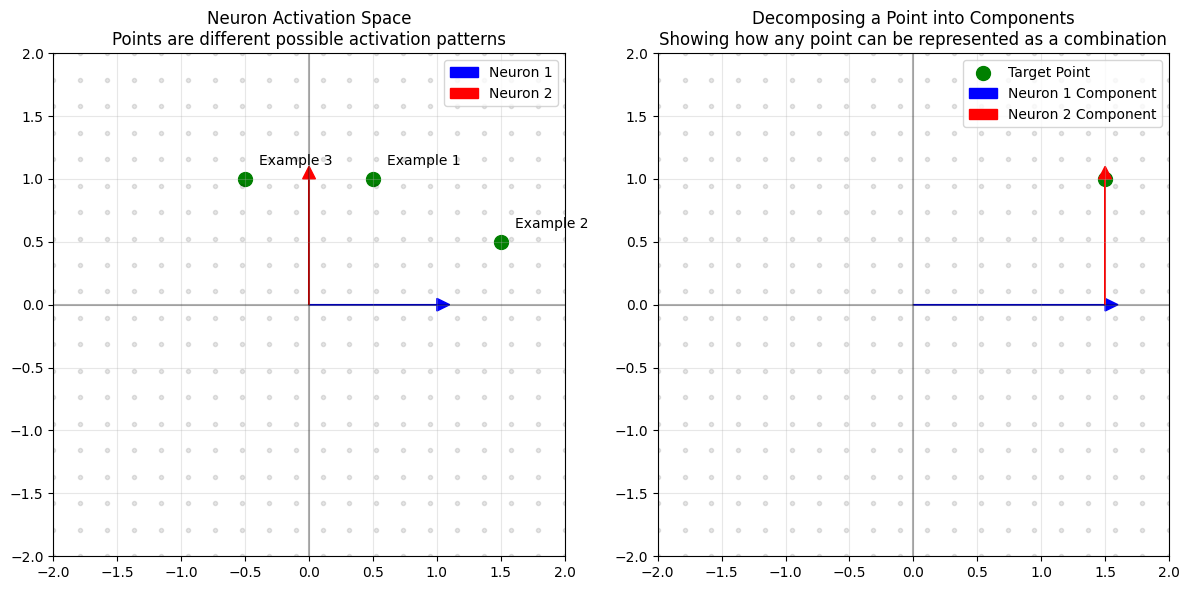

In [ ]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Basis Space
# Original neuron basis vectors
neuron1 = np.array([1, 0])
neuron2 = np.array([0, 1])

# Create a grid of points
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)

# Plot grid points
ax1.plot(X, Y, 'k.', alpha=0.1)

# Plot basis vectors
ax1.arrow(0, 0, neuron1[0], neuron1[1],
          head_width=0.1, head_length=0.1, fc='blue', ec='blue', label='Neuron 1')
ax1.arrow(0, 0, neuron2[0], neuron2[1],
          head_width=0.1, head_length=0.1, fc='red', ec='red', label='Neuron 2')

# Plot example activations
activations = [
    (0.5, 1.0, 'Example 1'),
    (1.5, 0.5, 'Example 2'),
    (-0.5, 1.0, 'Example 3')
]

for a1, a2, label in activations:
    point = a1*neuron1 + a2*neuron2
    ax1.scatter(point[0], point[1], c='green', s=100)
    ax1.annotate(label, (point[0], point[1]), xytext=(10, 10),
                textcoords='offset points')

# Plot settings for first subplot
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', alpha=0.3)
ax1.axvline(x=0, color='k', alpha=0.3)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_title('Neuron Activation Space\nPoints are different possible activation patterns')
ax1.legend()

# Second plot: Decomposition
# Point we want to represent
point = np.array([1.5, 1.0])

# Plot grid and axes
ax2.plot(X, Y, 'k.', alpha=0.1)

# Plot point
ax2.scatter(point[0], point[1], c='green', s=100, label='Target Point')

# Plot decomposition in original basis
ax2.arrow(0, 0, point[0], 0,
          head_width=0.1, head_length=0.1, fc='blue', ec='blue', label='Neuron 1 Component')
ax2.arrow(point[0], 0, 0, point[1],
          head_width=0.1, head_length=0.1, fc='red', ec='red', label='Neuron 2 Component')

# Plot settings for second subplot
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', alpha=0.3)
ax2.axvline(x=0, color='k', alpha=0.3)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_title('Decomposing a Point into Components\nShowing how any point can be represented as a combination')
ax2.legend()

plt.tight_layout()
plt.show()

### 3.2 "Random" Directions in Activation Space

We can choose "random" directions in this space: Combinations of basis vectors (neurons) that point to particular points in the space that were chosen at random, so without reason to believe that they would necessarily have meaning.

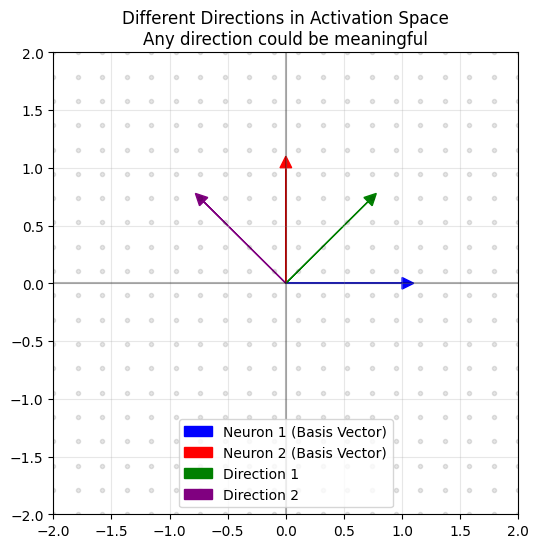

In [ ]:
# Now let's show how different directions can represent different things
plt.figure(figsize=(6,6))

# Original basis vectors
neuron1 = np.array([1, 0])
neuron2 = np.array([0, 1])

# Create some "meaningful" directions
direction1 = np.array([1, 1]) / np.sqrt(2)  # 45 degree direction
direction2 = np.array([-1, 1]) / np.sqrt(2)  # 135 degree direction

# Plot grid
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)
plt.plot(X, Y, 'k.', alpha=0.1)

# Plot original basis
plt.arrow(0, 0, neuron1[0], neuron1[1],
          head_width=0.1, head_length=0.1, fc='blue', ec='blue', label='Neuron 1 (Basis Vector)')
plt.arrow(0, 0, neuron2[0], neuron2[1],
          head_width=0.1, head_length=0.1, fc='red', ec='red', label='Neuron 2 (Basis Vector)')

# Plot new directions
plt.arrow(0, 0, direction1[0], direction1[1],
          head_width=0.1, head_length=0.1, fc='green', ec='green', label='Direction 1')
plt.arrow(0, 0, direction2[0], direction2[1],
          head_width=0.1, head_length=0.1, fc='purple', ec='purple', label='Direction 2')

# Plot settings
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', alpha=0.3)
plt.axvline(x=0, color='k', alpha=0.3)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title('Different Directions in Activation Space\nAny direction could be meaningful')
plt.legend()

plt.show()

### 3.3 Random Directions as Patterns in the Network

Another way to th

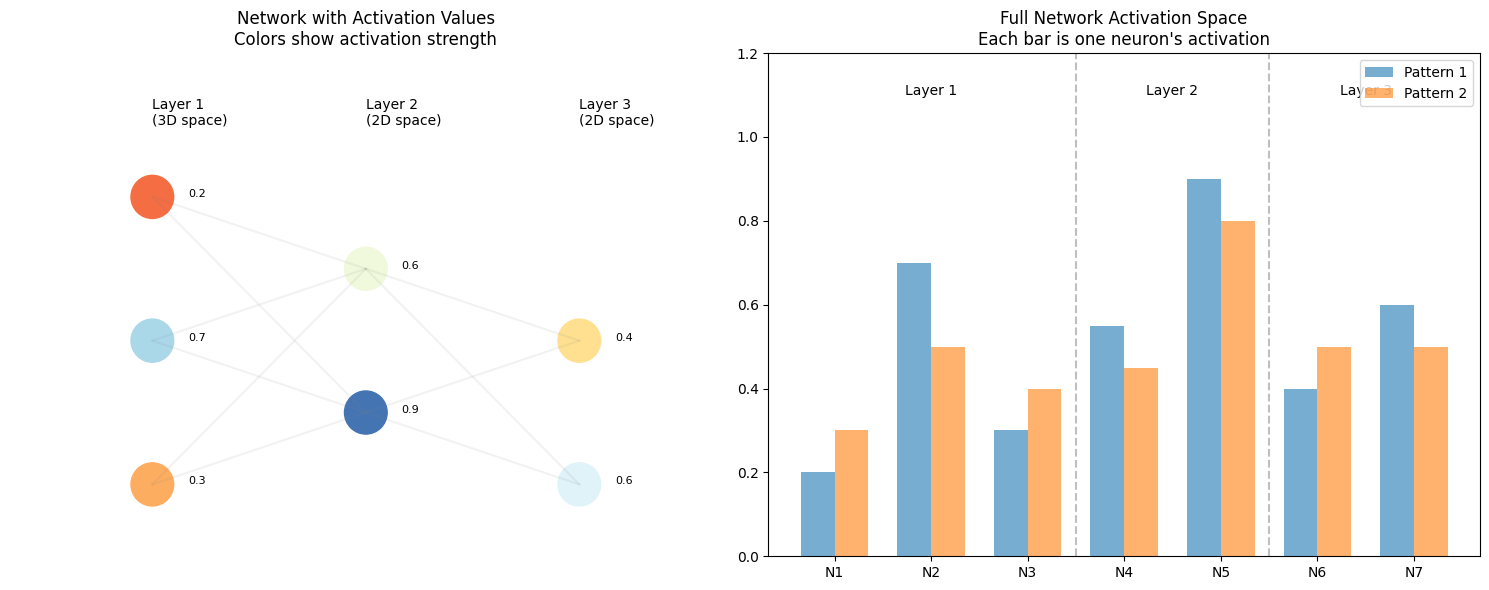

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arrow

def visualize_network_activations():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot: Network with activations
    def draw_network(ax):
        # Define layers
        layers = {
            'layer1': [(0.2, 0.7), (0.2, 0.5), (0.2, 0.3)],  # 3 neurons
            'layer2': [(0.5, 0.6), (0.5, 0.4)],              # 2 neurons
            'layer3': [(0.8, 0.5), (0.8, 0.3)]               # 2 neurons
        }

        # Draw neurons with activation values
        activation_values = {
            'layer1': [0.2, 0.7, 0.3],
            'layer2': [0.55, 0.9],
            'layer3': [0.4, 0.6]
        }

        # Draw connections
        for l1 in layers['layer1']:
            for l2 in layers['layer2']:
                ax.plot([l1[0], l2[0]], [l1[1], l2[1]], 'gray', alpha=0.1)
        for l2 in layers['layer2']:
            for l3 in layers['layer3']:
                ax.plot([l2[0], l3[0]], [l2[1], l3[1]], 'gray', alpha=0.1)

        # Draw neurons with colors based on activation
        for layer_name in layers:
            for i, (x, y) in enumerate(layers[layer_name]):
                activation = activation_values[layer_name][i]
                circle = Circle((x, y), 0.03, fill=True,
                              color=plt.cm.RdYlBu(activation))
                ax.add_patch(circle)
                # Add activation value
                ax.text(x+0.05, y, f'{activation:.1f}', fontsize=8)

        # Add layer labels
        ax.text(0.2, 0.8, 'Layer 1\n(3D space)', fontsize=10)
        ax.text(0.5, 0.8, 'Layer 2\n(2D space)', fontsize=10)
        ax.text(0.8, 0.8, 'Layer 3\n(2D space)', fontsize=10)

        ax.set_xlim(0, 1)
        ax.set_ylim(0.2, 0.9)
        ax.axis('off')
        ax.set_title('Network with Activation Values\nColors show activation strength')

    # Right plot: Combined activation space visualization
    def draw_activation_space(ax):
        # Create example vectors for visualization
        points = np.array([
            [0.2, 0.7, 0.3, 0.55, 0.9, 0.4, 0.6],  # One complete activation pattern
            [0.3, 0.5, 0.4, 0.45, 0.8, 0.5, 0.5]   # Another pattern
        ])

        # Create bar plot
        x = np.arange(7)
        width = 0.35

        ax.bar(x - width/2, points[0], width, label='Pattern 1', alpha=0.6)
        ax.bar(x + width/2, points[1], width, label='Pattern 2', alpha=0.6)

        # Add labels
        ax.set_xticks(x)
        ax.set_xticklabels(['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7'])

        # Add layer divisions
        ax.axvline(x=2.5, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=4.5, color='gray', linestyle='--', alpha=0.5)
        ax.text(1, 1.1, 'Layer 1', ha='center')
        ax.text(3.5, 1.1, 'Layer 2', ha='center')
        ax.text(5.5, 1.1, 'Layer 3', ha='center')

        ax.set_ylim(0, 1.2)
        ax.set_title('Full Network Activation Space\nEach bar is one neuron\'s activation')
        ax.legend()

    draw_network(ax1)
    draw_activation_space(ax2)
    plt.tight_layout()
    plt.show()

visualize_network_activations()

In [Szegdy et al.](https://arxiv.org/abs/1312.6199), they looked at the activation space of specific layers, so "random direction" in this context means a random combination of neurons within a layer.

They found these random combinations could be just as interpretable as individual neurons.

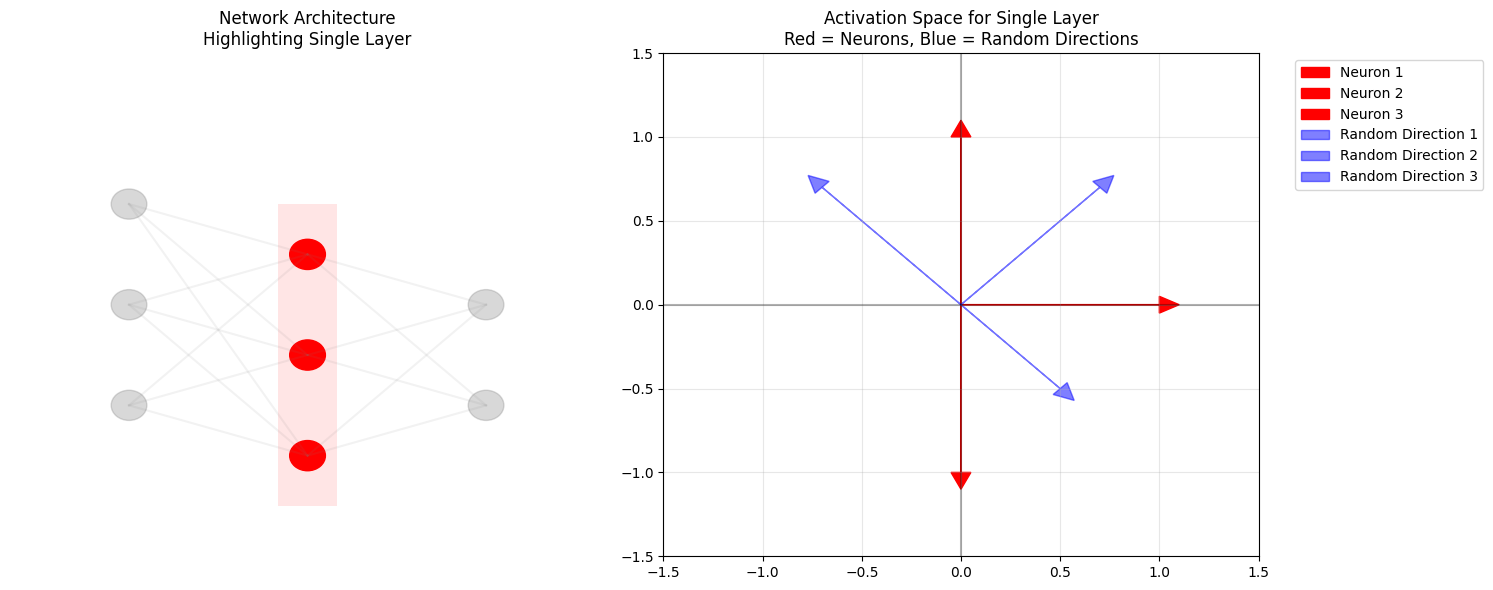

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arrow

def visualize_layer_directions():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Left: Network architecture highlighting a single layer
    def draw_network(ax):
        # Define layers
        layers = {
            'layer1': [(0.2, 0.7), (0.2, 0.5), (0.2, 0.3)],
            'layer2': [(0.5, 0.6), (0.5, 0.4), (0.5, 0.2)],  # Focus layer
            'layer3': [(0.8, 0.5), (0.8, 0.3)]
        }

        # Draw connections (grayed out)
        for l1 in layers['layer1']:
            for l2 in layers['layer2']:
                ax.plot([l1[0], l2[0]], [l1[1], l2[1]], 'gray', alpha=0.1)
        for l2 in layers['layer2']:
            for l3 in layers['layer3']:
                ax.plot([l2[0], l3[0]], [l2[1], l3[1]], 'gray', alpha=0.1)

        # Draw neurons
        for layer_name, positions in layers.items():
            color = 'red' if layer_name == 'layer2' else 'gray'
            alpha = 1.0 if layer_name == 'layer2' else 0.3
            for x, y in positions:
                circle = Circle((x, y), 0.03, fill=True, color=color, alpha=alpha)
                ax.add_patch(circle)

        # Highlight middle layer
        ax.add_patch(plt.Rectangle((0.45, 0.1), 0.1, 0.6,
                                 facecolor='red', alpha=0.1))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.set_title('Network Architecture\nHighlighting Single Layer')

    # Right: Activation space for that layer
    def draw_activation_space(ax):
        # Plot basis vectors (individual neurons)
        ax.arrow(0, 0, 1, 0, head_width=0.1, head_length=0.1, fc='red', ec='red',
                label='Neuron 1')
        ax.arrow(0, 0, 0, 1, head_width=0.1, head_length=0.1, fc='red', ec='red',
                label='Neuron 2')
        ax.arrow(0, 0, 0, -1, head_width=0.1, head_length=0.1, fc='red', ec='red',
                label='Neuron 3')

        # Plot random directions
        random_dirs = [
            (0.7, 0.7), (-0.7, 0.7), (0.5, -0.5)
        ]

        for i, (dx, dy) in enumerate(random_dirs):
            ax.arrow(0, 0, dx, dy, head_width=0.1, head_length=0.1,
                    fc='blue', ec='blue', alpha=0.5,
                    label=f'Random Direction {i+1}')

        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', alpha=0.3)
        ax.axvline(x=0, color='k', alpha=0.3)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_title('Activation Space for Single Layer\nRed = Neurons, Blue = Random Directions')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    draw_network(ax1)
    draw_activation_space(ax2)
    plt.tight_layout()
    plt.show()

visualize_layer_directions()

The finding about random directions being meaningful suggests that:

1. Individual neurons aren't special
2. The layer as a whole represents features in a distributed way
3. Many different combinations of neurons within a layer might capture meaningful features